In [1]:
%matplotlib
import os
import sys
from IPython import display

from rich import print
from tensorflow.python.keras.metrics import accuracy

from nn.wandb_classification_callback import WandbClassificationCallback

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import datetime
from collections import Counter
from typing import Any, Dict, List

import tensorflow as tf
import wandb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import PIL
import imageio

from data_analysis.py_color import PyColor
from data_analysis.utils import Utils
from nn.losses import EDLLoss
from nn.model_base import VDANN

# from nn.metrics import CategoricalTruePositives
from pre_process.pre_process import PreProcess
from pre_process.record import Record
import random

# from wandb.keras import WandbCallback

Using matplotlib backend: agg


In [2]:
def set_seed(seed=200):
    tf.random.set_seed(seed)
    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    return

In [3]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0
    return np.where(images > 0.5, 1.0, 0.0).astype("float32")

In [4]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(model, z)
#   eps = tf.random.normal(shape=mean.shape)
#   reparameterized = eps * tf.exp(logvar * 0.5) + mean
#   predictions = model.decoder(reparameterized)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  plt.close()

In [5]:
# 環境設定
set_seed(0)
CALC_DEVICE = "gpu"
DEVICE_ID = "0" if CALC_DEVICE == "gpu" else "-1"
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE_ID
if os.environ["CUDA_VISIBLE_DEVICES"] != "-1":
    tf.keras.backend.set_floatx("float32")
    physical_devices = tf.config.list_physical_devices("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.run_functions_eagerly(True)
else:
    print("*** cpuで計算します ***")
    # なんか下のやつ使えなくなっている、、
    tf.config.run_functions_eagerly(True)

# ハイパーパラメータの設定
TEST_RUN = False
EPOCHS = 10
HAS_ATTENTION = True
PSE_DATA = False
HAS_INCEPTION = True
IS_PREVIOUS = False
IS_NORMAL = True
HAS_DROPOUT = True
IS_ENN = False
# FIXME: 多層化はとりあえずいらない
IS_MUL_LAYER = True
HAS_NREM2_BIAS = False
HAS_REM_BIAS = False
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
N_CLASS = 10
# KERNEL_SIZE = 512
# KERNEL_SIZE = 256
KERNEL_SIZE = 128
STRIDE = 16
# STRIDE = 16
SAMPLE_SIZE = 10000
DATA_TYPE = "spectrogram"
FIT_POS = "middle"
CLEANSING_TYPE = "no_cleansing"
NORMAL_TAG = "normal" if IS_NORMAL else "sas"
ATTENTION_TAG = "attention" if HAS_ATTENTION else "no-attention"
PSE_DATA_TAG = "psedata" if PSE_DATA else "sleepdata"
INCEPTION_TAG = "inception" if HAS_INCEPTION else "no-inception"
WANDB_PROJECT = "test" if TEST_RUN else "1215_test"
# WANDB_PROJECT = "test" if TEST_RUN else "base_learning_20211109"
ENN_TAG = "enn" if IS_ENN else "dnn"
INCEPTION_TAG += "v2" if IS_MUL_LAYER else ""

In [6]:
# データセットの作成
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)
train_size = 60000
batch_size = 128
test_size = 10000
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(train_size)
    .batch(batch_size)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .shuffle(test_size)
    .batch(batch_size)
)
data_type = "spectrogram"
shape = (28, 28, 1)
inputs = tf.keras.Input(shape=shape)

epochs = EPOCHS
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 4
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)
model = VDANN(
    inputs=inputs,
    gamma=1,
    latent_dim=latent_dim,
    alpha=0,
    beta=0,
    target_dim=5,
    subject_dim=68,
    has_inception=HAS_INCEPTION,
    has_attention=HAS_ATTENTION,
)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
# )

In [7]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(train_size)
    .batch(batch_size)
)

In [8]:
for example in train_dataset.take(1):
    tmp = example

In [9]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch_x, test_batch_y in test_dataset.take(1):
  test_sample_x = test_batch_x[0:num_examples_to_generate, :, :, :]
  test_sample_y = test_batch_y[0:num_examples_to_generate]

In [10]:
def show_true_image(x):
    fig = plt.figure(figsize=(4, 4))
    for i in range(x.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(x[i, :, :, 0], cmap='gray')
        plt.axis('off')
#     plt.savefig("original_image_of_mine.png")
    plt.show()

show_true_image(test_sample_x)

In [11]:
generate_and_save_images(model, 0, test_sample_x)

In [12]:
# model_baes内にGPUの計算中にnumpyに渡すことが出来ないのでmainにlambda式用意
tensor2numpy = lambda x: x.numpy()
vae_opt = tf.keras.optimizers.Adam(1e-4)
tar_opt = tf.keras.optimizers.Adam(1e-4)
for epoch in range(epochs):
    vae_test_loss_metric = tf.keras.metrics.Mean()
    tar_test_loss_metric = tf.keras.metrics.Mean()
    # print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, data in enumerate(train_dataset):
        train_loss = model.train_step(data, vae_opt, tar_opt)
        # if step % 50 == 0:
        #     print(
        #         f"train loss: (vae, sbj, tar) =  {tuple(map(tensor2numpy, train_loss))}"
        #     )
    # train_metrics.reset_states()

    for step, data in enumerate(test_dataset):
        test_loss = model.test_step(data)
        vae_test_loss_metric(test_loss[0])
        tar_test_loss_metric(test_loss[1])
    vae_elbo = vae_test_loss_metric.result()
    tar_elbo = tar_test_loss_metric.result()
    display.clear_output(wait=False)
    # print(
    #     f"test loss: (vae, sbj, tar) = {tuple(map(tensor2numpy, test_loss))}"
    # )
    print(f"Epoch: {epoch}, Test set VAE ELBO: {vae_elbo}")
    print(f"Epoch: {epoch}, Test set tar loss: {tar_elbo}")
    # test_metrics.reset_states()
    generate_and_save_images(model, epoch, test_sample_x)

Epoch: 9, Test set VAE ELBO: nan

Epoch: 9, Test set tar loss: nan

In [13]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [14]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

(-0.5, 399.5, 399.5, -0.5)

In [15]:
import glob
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


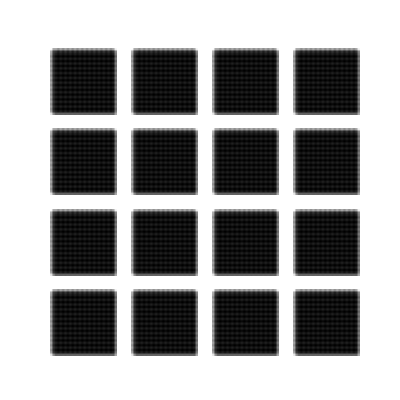

In [16]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# 潜在変数空間を描画する

In [17]:
x_test[::100].shape

(100, 28, 28, 1)

In [18]:
# 100個おきに入れる
data = x_test[::10], y_test[::10]
mean, logvar = model.encode(data[0])
# 潜在変数空間
z = model.reparameterize(mean, logvar)
# 描画
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = ax.scatter(z[:, 0], z[:, 1], c=data[1])
cbar = fig.colorbar(im)
plt.savefig("only_vae.png")

# 入力データを見てみる

In [19]:
x_train.shape

(60000, 28, 28, 1)

In [20]:
plt.imshow(test_sample[6], cmap='gray')

NameError: name 'test_sample' is not defined

In [ ]:
def show_true_image(x):
    fig = plt.figure(figsize=(4, 4))
    for i in range(x.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(x[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig("original_image.png")
    plt.show()

show_true_image(test_sample)